In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from keras.datasets import mnist
import random

2024-12-20 23:57:05.708655: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 23:57:05.709973: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 23:57:05.737159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-20 23:57:06.215958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from models import MLPAutoEncoder, ConvAutoEncoder

In [3]:
(x_train, y_train), (_, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0

In [4]:
counts = dict(zip(*np.unique(y_train, return_counts=True)))

data = {i:np.zeros((counts[i], 28, 28), dtype=np.float32) for i in range(10)}
fill_cntr = {i:0 for i in range(10)}

for x, y in zip(x_train, y_train):
    data[y][fill_cntr[y]] = x
    fill_cntr[y] += 1

def get_batch(batch_size):
    x_batch = np.zeros((batch_size, 28, 28), dtype=np.float32)
    y_batch = np.zeros((batch_size, 28, 28), dtype=np.float32)

    for i in range(batch_size):
        c = random.randint(0, 8)
        x_batch[i] = data[c][random.randint(0, counts[c]) - 1]
        y_batch[i] = data[c+1][random.randint(0, counts[c+1]) - 1]

    return x_batch, y_batch

In [5]:

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.005

# train a convolutional autoencoder on MNIST
mlp_model = ConvAutoEncoder().to(DEVICE)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.MSELoss()
inspections = []

for epoch in range(EPOCHS):
    print("Epoch: " + str(epoch + 1) + "/" + str(EPOCHS))
    epoch_loss = 0
    updates = 0

    for i in range(0, len(x_train), BATCH_SIZE):
        #batch = x_train[i:i + BATCH_SIZE].reshape(-1, 1, 28, 28)
        #batch = torch.from_numpy(batch).to(DEVICE)
        
        x_batch, y_batch = get_batch(BATCH_SIZE)
        assert x_batch.shape == (BATCH_SIZE, 28, 28)
        assert y_batch.shape == (BATCH_SIZE, 28, 28)
        assert x_batch.dtype == np.float32
        assert y_batch.dtype == np.float32

        x_batch = torch.from_numpy(x_batch.reshape(BATCH_SIZE, 1, 28, 28)).to(DEVICE)
        y_batch = torch.from_numpy(y_batch.reshape(BATCH_SIZE, 1, 28, 28)).to(DEVICE)

        # forward pass
        output = mlp_model(x_batch)
        loss = criterion(output, y_batch)

        epoch_loss += loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        updates += 1

        print(
            "update: " + str(updates) + "/" + str(len(x_train)//BATCH_SIZE + 1) + " | " +
            "loss: " + str(round(epoch_loss/updates, 5)), end="\r")

    print(
        "update: " + str(updates) + "/" + str(len(x_train)//BATCH_SIZE + 1) + " | " +
        "loss: " + str(round(epoch_loss/updates, 5)))

    if (epoch % 2 == 0 and len(inspections) < 4) or epoch == EPOCHS - 1:
        inspections.append((
            epoch, 
            x_batch.to("cpu").detach().numpy(), 
            output.to("cpu").detach().numpy()
        ))

Epoch: 1/20
update: 469/469 | loss: 0.05684
Epoch: 2/20
update: 469/469 | loss: 0.05321
Epoch: 3/20
update: 469/469 | loss: 0.05319
Epoch: 4/20
update: 469/469 | loss: 0.05311
Epoch: 5/20
update: 469/469 | loss: 0.05307
Epoch: 6/20
update: 469/469 | loss: 0.05285
Epoch: 7/20
update: 469/469 | loss: 0.05285
Epoch: 8/20
update: 469/469 | loss: 0.05289
Epoch: 9/20
update: 469/469 | loss: 0.05299
Epoch: 10/20
update: 469/469 | loss: 0.05301
Epoch: 11/20
update: 469/469 | loss: 0.05294
Epoch: 12/20
update: 469/469 | loss: 0.05286
Epoch: 13/20
update: 469/469 | loss: 0.05301
Epoch: 14/20
update: 469/469 | loss: 0.05291
Epoch: 15/20
update: 469/469 | loss: 0.05285
Epoch: 16/20
update: 469/469 | loss: 0.05304
Epoch: 17/20
update: 469/469 | loss: 0.05296
Epoch: 18/20
update: 469/469 | loss: 0.05275
Epoch: 19/20
update: 469/469 | loss: 0.05292
Epoch: 20/20
update: 469/469 | loss: 0.05277


/tmp/ipykernel_1512926/2959362879.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 9, i+1)


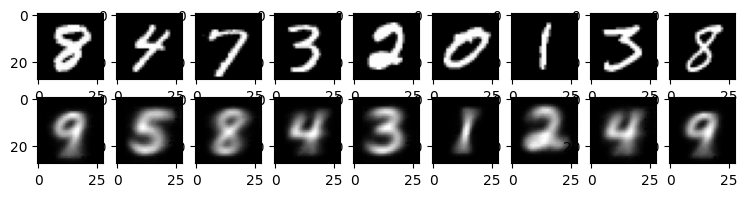

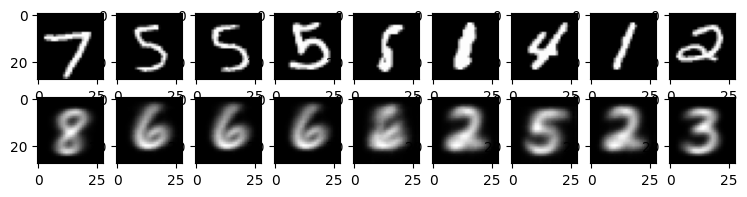

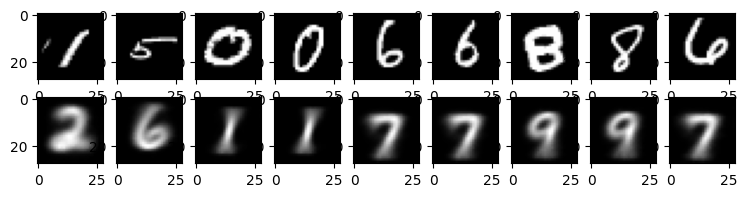

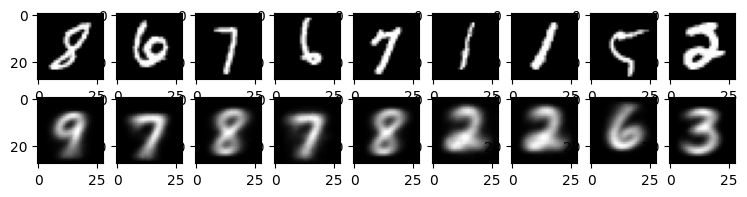

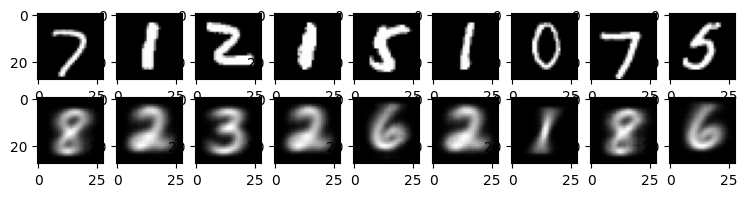

In [6]:
# examine how proficient the convolutional autoencoder is at reconstructing over epochs
for epoch, imgs, recons in inspections:
    plt.figure(figsize=(9, 2))
    plt.title("Epoch " + str(epoch + 1))
    plt.gray()
    for i, img in enumerate(imgs[:9]):
        plt.subplot(2, 9, i+1)
        plt.imshow(img.reshape(28, 28))
    for i, recon in enumerate(recons[:9]):
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(recon.reshape(28, 28))